<a href="https://colab.research.google.com/github/FaQ2108/Trading-Algoritmico-con-SmallCaps/blob/main/Estrategia3_MACD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estrategia MACD en Trading Algorítmico

El **MACD (Moving Average Convergence Divergence)** es un indicador muy popular que ayuda a identificar cambios en la tendencia de un activo. A continuación, se explica de manera sencilla cómo funciona y cómo se aplica en el trading algorítmico.

## ¿Qué es el MACD?

- **Promedios Móviles Exponenciales (EMA):**  
  Se utilizan dos EMAs: una de corto plazo (por ejemplo, 12 períodos) y otra de largo plazo (por ejemplo, 26 períodos).

- **Línea MACD:**  
  Se obtiene restando la EMA de largo plazo de la EMA de corto plazo. Esta línea muestra la diferencia entre ambos promedios.

- **Línea de Señal:**  
  Es una EMA (usualmente de 9 períodos) calculada sobre la línea MACD, que suaviza sus movimientos.

- **Histograma:**  
  Representa la diferencia entre la línea MACD y la línea de señal, facilitando la visualización de la fuerza del movimiento.

## Señales de Trading

- **Señal de Compra:**  
  Ocurre cuando la línea MACD cruza por encima de la línea de señal, indicando que el impulso alcista está aumentando.

- **Señal de Venta:**  
  Se produce cuando la línea MACD cruza por debajo de la línea de señal, sugiriendo que el impulso bajista está ganando fuerza.

## Aplicación en Trading Algorítmico

En el trading algorítmico, estas reglas se programan para ejecutar operaciones de forma automática:

1. **Cálculo Automático:**  
   El algoritmo procesa los datos de precios en tiempo real y calcula las EMAs, la línea MACD y la línea de señal.

2. **Detección de Cruces:**  
   Se monitorean los cruces entre la línea MACD y la línea de señal para generar señales de compra o venta.

3. **Ejecución de Órdenes:**  
   Con base en las señales detectadas, el sistema ejecuta automáticamente las órdenes de compra o venta siguiendo reglas predefinidas.

## Consideraciones Importantes

- **Retraso en la Señal:**  
  Debido a que el MACD utiliza promedios, puede presentar un retraso en la detección de cambios de tendencia.

- **Confirmación con Otros Indicadores:**  
  Es aconsejable combinar el MACD con otros indicadores o filtros para confirmar las señales y reducir el riesgo de señales falsas.

- **Backtesting y Ajustes:**  
  Antes de operar en vivo, se debe probar la estrategia con datos históricos para ajustar parámetros y validar su efectividad.

---

En resumen, la estrategia MACD en trading algorítmico se basa en identificar cruces entre dos medias móviles para generar señales de compra o venta, permitiendo una toma de decisiones automatizada y objetiva.

In [ ]:
!pip install pandas sqlalchemy pymysql h5py google-colab
!pip install pandas_ta
!pip install tables
!pip install --upgrade tables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=fc5051f982781201af9b405afc9057ac89bb7d2379d684c0765ab6a0a60c45e1
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [ ]:
from getpass import getpass  # Importar getpass para ocultar la entrada de la contraseña
import pandas as pd
import sqlalchemy as db
from sqlalchemy.exc import SQLAlchemyError
import h5py
from google.colab import drive
import os

class DatabaseAnalyzer:
    def __init__(self):
        self.engine = None
        self.cleaned_dataframes = {}

    def get_db_connection(self):
        try:
            host = input("Introduce el host de la base de datos: ")
            user = input("Introduce el usuario de la base de datos: ")
            password = getpass("Introduce la contraseña de la base de datos: ")  # Oculta la contraseña
            database = input("Introduce el nombre de la base de datos: ")

            connection_string = f"mysql+pymysql://{user}:{password}@{host}/{database}"
            self.engine = db.create_engine(connection_string)
            print("Conexión establecida correctamente.")
            self.analyze_tables()
        except SQLAlchemyError as e:
            print(f"Error al conectar a la base de datos: {e}")

    def count_nulls(self, df):
        return df.isnull().sum()

    def analyze_tables(self):
        try:
            # Proceso de limpieza para la tabla vista_datos_completos
            query_vista = "SELECT * FROM vista_datos_completos"
            df_vista = pd.read_sql(query_vista, self.engine)
            print("Valores nulos antes de la limpieza (vista_datos_completos):")
            print(self.count_nulls(df_vista))

            columns_to_check = df_vista.columns.difference(['spread', 'short_float'])
            df_vista_cleaned = df_vista.dropna(subset=columns_to_check, how='any')

            print("Valores nulos después de la limpieza (vista_datos_completos):")
            print(self.count_nulls(df_vista_cleaned))

            # Aplicar el filtro adicional a vista_datos_completos
            df_vista_cleaned = self.filter_vista_datos_completos(df_vista_cleaned)
            # **Filtro nuevo:** Filtrar por horarios entre 15:30 y 22:00 usando la columna 'fecha'
            df_vista_cleaned = self.filter_by_time(df_vista_cleaned, 'fecha')

            # Proceso de limpieza para la tabla OHLCData
            query_ohlc = "SELECT * FROM OHLCData"
            df_ohlc = pd.read_sql(query_ohlc, self.engine)
            print("Valores nulos antes de la limpieza (OHLCData):")
            print(self.count_nulls(df_ohlc))

            # Limpiar nulos en OHLCData
            df_ohlc_cleaned = df_ohlc.dropna()
            # **Filtro nuevo:** Filtrar por horarios entre 15:30 y 22:00 usando la columna 'date'
            df_ohlc_cleaned = self.filter_by_time(df_ohlc_cleaned, 'date')

            print("Valores nulos después de la limpieza (OHLCData):")
            print(self.count_nulls(df_ohlc_cleaned))

            # Obtener los id_event que cumplen con las condiciones en ambas tablas
            cleaned_events_vista = df_vista_cleaned['id_event'].unique()
            cleaned_events_ohlc = df_ohlc_cleaned['id_event'].unique()

            # Encontrar la intersección de id_event entre ambas tablas
            common_events = set(cleaned_events_vista).intersection(set(cleaned_events_ohlc))

            # Filtrar ambas tablas para mantener solo los registros con id_event comunes
            df_vista_final = df_vista_cleaned[df_vista_cleaned['id_event'].isin(common_events)]
            df_ohlc_final = df_ohlc_cleaned[df_ohlc_cleaned['id_event'].isin(common_events)]

            # Se guardan ambas tablas: vista_datos_completos y OHLCData limpias.
            self.cleaned_dataframes['vista_datos_completos'] = df_vista_final
            self.cleaned_dataframes['OHLCData'] = df_ohlc_final

            print("Tablas vista_datos_completos y OHLCData filtradas y limpias guardadas correctamente.")
        except Exception as e:
            print(f"Error al analizar las tablas: {e}")

    def filter_vista_datos_completos(self, df):
        """
        Filtra la tabla vista_datos_completos según las condiciones:
        - percent_var_max < 500
        - percent_var_min > -40
        - ratio_vol < 1500
        - float_shares < 3000000
        - market_cap < 300000000
        - precio < 10
        """
        try:
            required_columns = ['precio', 'float_shares', 'market_cap']
            if all(column in df.columns for column in required_columns):
                filtered_df = df[(df['percent_var'] < 500) & (df['percent_var'] > -40) &
                                 (df['ratio_vol'] < 1500) &
                                 (df['float_shares'] < 3000000) &
                                 (df['market_cap'] < 300000000) &
                                 (df['precio'] < 10)]
                print("vista_datos_completos filtrada según las condiciones especificadas.")
                return filtered_df
            else:
                print("Advertencia: No se encontraron todas las columnas requeridas para el filtrado.")
                return df
        except Exception as e:
            print(f"Error al filtrar vista_datos_completos: {e}")
            return df

    def filter_by_time(self, df, time_column):
        """
        Filtra un DataFrame para incluir solo registros cuyo valor en la columna de tiempo esté entre las 15:30 y las 22:00.
        Se asume que la columna indicada contiene valores que pueden convertirse a datetime.
        """
        try:
            if time_column not in df.columns:
                print(f"Columna '{time_column}' no encontrada en el DataFrame. Se omite el filtro por tiempo.")
                return df

            # Convertir la columna a datetime (en caso de que no lo sea)
            df.loc[:, time_column] = pd.to_datetime(df[time_column], errors='coerce')

            # Definir los límites de hora
            hora_inicio = pd.to_datetime("15:30").time()
            hora_fin = pd.to_datetime("22:00").time()
            # Filtrar el DataFrame
            filtered_df = df[(df[time_column].dt.time >= hora_inicio) & (df[time_column].dt.time <= hora_fin)]
            print(f"Filtrado por horario entre 15:30 y 22:00 en la columna '{time_column}'.")
            return filtered_df
        except Exception as e:
            print(f"Error al filtrar por horario: {e}")
            return df

    def save_cleaned_data_to_hdf5(self, file_path):
        try:
            if self.cleaned_dataframes:
                # Verificar si el archivo ya existe
                if os.path.exists(file_path):
                    overwrite = input(f"El archivo {file_path} ya existe. ¿Desea sobrescribirlo? (s/n): ").strip().lower()
                    if overwrite != 's':
                        new_file_path = input("Introduce la nueva ruta del archivo HDF5: ")
                        file_path = new_file_path

                # Forzar el cierre del archivo si está abierto
                try:
                    import tables
                    if tables.is_hdf5_file(file_path):
                        with pd.HDFStore(file_path, mode='r') as store:
                            store.close()
                except Exception:
                    pass

                # Guardar los DataFrames en el archivo HDF5
                with pd.HDFStore(file_path, mode='w') as store:
                    for table_name, df in self.cleaned_dataframes.items():
                        store.put(table_name, df)
                        print(f"Tabla '{table_name}' guardada en {file_path}")
            else:
                print("No hay datos limpios para guardar.")
        except Exception as e:
            print(f"Error al guardar los DataFrames en HDF5: {e}")


# Montar Google Drive (si ya está montado, este mensaje se puede omitir o forzarse el remount con force_remount=True)
drive.mount('/content/drive')

# Crear una instancia de DatabaseAnalyzer
analyzer = DatabaseAnalyzer()

# Establecer la conexión a la base de datos
analyzer.get_db_connection()

# Guardar los DataFrames limpios y filtrados en un archivo HDF5
file_path = '/content/drive/MyDrive/Proyecto_SmallCaps/BBDD/bbdd_filtrada.h5'
analyzer.save_cleaned_data_to_hdf5(file_path)

Mounted at /content/drive
Introduce el host de la base de datos: librobot.org
Introduce el usuario de la base de datos: faq2108
Introduce la contraseña de la base de datos: ··········
Introduce el nombre de la base de datos: smallcaps
Conexión establecida correctamente.
Valores nulos antes de la limpieza (vista_datos_completos):
ticker            0
id_event          0
fecha             0
percent_var       0
ratio_vol         0
precio            3
volumen           0
spread           67
insercion         0
anterior          0
apertura          0
float_shares    373
exchange        213
country         213
avg_volume      213
shs_outstand    226
market_cap      215
inst_own        213
short_float     383
dtype: int64
Valores nulos después de la limpieza (vista_datos_completos):
ticker           0
id_event         0
fecha            0
percent_var      0
ratio_vol        0
precio           0
volumen          0
spread          55
insercion        0
anterior         0
apertura         0
float

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# Ruta al archivo HDF5 generado previamente
data_path = "/content/drive/MyDrive/Proyecto_SmallCaps/BBDD/bbdd_filtrada.h5"

# Cargar datos desde la tabla 'OHLCData'
with pd.HDFStore(data_path, "r") as store:
    df = store["OHLCData"]

# Filtrar datos: descartamos registros con volumen 0
df = df[df["volume"] > 0].reset_index(drop=True)
print("Datos cargados:", df.shape)

# Convertir la columna 'date' a datetime, si aún no lo está
df["date"] = pd.to_datetime(df["date"])

df.head()

Datos cargados: (133535, 9)


,id_ohlc,id_event,date,open,high,low,close,volume,synced
0,1,1,2025-01-15 13:41:00,1.596,1.596,1.596,1.596,220,0
1,2,1,2025-01-15 14:31:00,1.600,1.670,1.600,1.670,13153,0
2,3,1,2025-01-15 14:32:00,1.670,1.796,1.620,1.720,18957,0
3,4,1,2025-01-15 14:33:00,1.750,1.750,1.640,1.640,6224,0
4,5,1,2025-01-15 14:34:00,1.700,1.700,1.560,1.561,12956,0


In [ ]:
def calcular_macd(df_event, fast_period=12, slow_period=26, signal_period=9):
    """
    Calcula el MACD, la línea de señal y (opcionalmente) el histograma para un DataFrame con precios de cierre.
    Retorna el DataFrame con columnas adicionales: 'MACD' y 'MACD_signal'.
    """
    df_event = df_event.sort_values("date").reset_index(drop=True)

    # 1) EMA de período rápido
    ema_fast = df_event["close"].ewm(span=fast_period, adjust=False).mean()

    # 2) EMA de período lento
    ema_slow = df_event["close"].ewm(span=slow_period, adjust=False).mean()

    # 3) Línea MACD (diferencia)
    df_event["MACD"] = ema_fast - ema_slow

    # 4) Línea de señal (EMA de la línea MACD)
    df_event["MACD_signal"] = df_event["MACD"].ewm(span=signal_period, adjust=False).mean()

    # (Opcional) Histograma
    # df_event["MACD_hist"] = df_event["MACD"] - df_event["MACD_signal"]

    return df_event

In [ ]:
def aplicar_estrategia_macd(df_event, fast_period=12, slow_period=26, signal_period=9, min_candles=30):
    """
    Aplica la estrategia de MACD a un DataFrame de un evento.
    Crea columnas: MACD, MACD_signal, Compra, Venta.
    Si el evento tiene menos de 'min_candles', retorna None.
    """
    if len(df_event) < min_candles:
        return None

    # Ordenar por fecha
    df_event = df_event.sort_values("date").reset_index(drop=True)

    # Calcular MACD y señal
    df_event = calcular_macd(df_event, fast_period, slow_period, signal_period)

    # Señal de Compra: MACD cruza por encima de la línea de señal
    df_event["Compra"] = (
        (df_event["MACD"] > df_event["MACD_signal"]) &
        (df_event["MACD"].shift(1) <= df_event["MACD_signal"].shift(1))
    )

    # Señal de Venta: MACD cruza por debajo de la línea de señal
    df_event["Venta"] = (
        (df_event["MACD"] < df_event["MACD_signal"]) &
        (df_event["MACD"].shift(1) >= df_event["MACD_signal"].shift(1))
    )

    return df_event

In [ ]:
resultados_macd = {}
event_ids = df["id_event"].unique()

for event in event_ids:
    df_event = df[df["id_event"] == event].copy()
    df_event_proc = aplicar_estrategia_macd(df_event, fast_period=12, slow_period=26, signal_period=9, min_candles=30)
    if df_event_proc is not None:
        resultados_macd[event] = df_event_proc

In [ ]:
def calcular_pnl_macd(df_event, stop_loss_pct=5.0):
    """
    Calcula el PnL de un evento basándose en:
      - Primera señal 'Compra' como entrada (precio de cierre de esa vela).
      - Primera señal 'Venta' posterior como salida (o el stop loss si se activa antes).
      - Si no hay 'Venta', salimos en la última vela.
    """
    df_event = df_event.sort_values("date").reset_index(drop=True)

    # Buscar el índice de la primera señal de compra
    buy_indices = df_event.index[df_event["Compra"] == True].tolist()
    if not buy_indices:
        return None  # No hay compra, no hay operación

    buy_idx = buy_indices[0]
    entry_price = df_event.loc[buy_idx, "close"]
    entry_date  = df_event.loc[buy_idx, "date"]

    exit_price = None
    exit_date = None
    motivo = ""

    # Recorrer desde la vela siguiente a la compra
    for idx in range(buy_idx + 1, len(df_event)):
        fila = df_event.iloc[idx]

        # Stop Loss
        if fila["low"] <= entry_price * (1 - stop_loss_pct/100):
            exit_price = entry_price * (1 - stop_loss_pct/100)
            exit_date  = fila["date"]
            motivo = "Stop Loss"
            break

        # Señal de Venta
        if fila["Venta"] == True:
            exit_price = fila["close"]
            exit_date  = fila["date"]
            motivo = "Venta (MACD)"
            break

    # Si no se encontró salida, usar la última vela
    if exit_price is None:
        exit_price = df_event.iloc[-1]["close"]
        exit_date  = df_event.iloc[-1]["date"]
        motivo = "Fin del Evento (sin Venta)"

    # Calcular PnL
    pnl_pct = ((exit_price - entry_price) / entry_price) * 100

    return {
        "entry_date": entry_date,
        "entry_price": entry_price,
        "exit_date": exit_date,
        "exit_price": exit_price,
        "motivo_exit": motivo,
        "pnl_pct": pnl_pct
    }

In [ ]:
resumen_operaciones_macd = []

for event_id, df_event in resultados_macd.items():
    resultado = calcular_pnl_macd(df_event, stop_loss_pct=5.0)
    if resultado is not None:
        resultado["id_event"] = event_id
        resumen_operaciones_macd.append(resultado)

df_operaciones_macd = pd.DataFrame(resumen_operaciones_macd)

In [ ]:
df_positivos_macd = df_operaciones_macd[df_operaciones_macd["pnl_pct"] > 0]
top10_macd = df_positivos_macd.sort_values("pnl_pct", ascending=False).head(10)

In [ ]:
import plotly.graph_objects as go

for event in top10_macd["id_event"]:
    df_plot = resultados_macd[event].sort_values("date").reset_index(drop=True)

    op = top10_macd[top10_macd["id_event"] == event].iloc[0]
    entry_date  = op["entry_date"]
    exit_date   = op["exit_date"]
    entry_price = op["entry_price"]
    exit_price  = op["exit_price"]
    pnl_pct     = op["pnl_pct"]

    fig = go.Figure()
    # Candlestick
    fig.add_trace(go.Candlestick(
        x=df_plot["date"],
        open=df_plot["open"],
        high=df_plot["high"],
        low=df_plot["low"],
        close=df_plot["close"],
        name="OHLC"
    ))

    # MACD (como una línea)
    fig.add_trace(go.Scatter(
        x=df_plot["date"],
        y=df_plot["MACD"],
        mode="lines",
        name="MACD",
        line=dict(color="blue")
    ))

    # MACD Signal
    fig.add_trace(go.Scatter(
        x=df_plot["date"],
        y=df_plot["MACD_signal"],
        mode="lines",
        name="MACD Signal",
        line=dict(color="orange", dash="dot")
    ))

    # Entrada
    fig.add_trace(go.Scatter(
        x=[entry_date],
        y=[entry_price],
        mode="markers",
        marker=dict(color="green", size=10, symbol="triangle-up"),
        name="Entrada"
    ))

    # Salida
    fig.add_trace(go.Scatter(
        x=[exit_date],
        y=[exit_price],
        mode="markers",
        marker=dict(color="red", size=10, symbol="triangle-down"),
        name="Salida"
    ))

    fig.update_layout(
        title=f"Evento {event} (MACD) - PnL: {pnl_pct:.2f}%",
        xaxis_title="Fecha",
        yaxis_title="Precio",
        xaxis_rangeslider_visible=False
    )

    fig.show()

# Informe: Estrategia MACD para SmallCaps

---

## 1. Descripción del MACD

El **MACD** (Moving Average Convergence/Divergence) es un indicador de tendencia que se construye a partir de dos medias móviles exponenciales de diferente período:

1. **Línea MACD**: Se calcula como la diferencia entre la EMA de período corto y la EMA de período largo (por ejemplo, 12 y 26 velas).  
2. **Línea de Señal**: Es la EMA (generalmente de 9 velas) aplicada sobre la propia línea MACD.  
3. (Opcional) **Histograma**: Representa la diferencia entre la línea MACD y la línea de señal.

El MACD es popular por combinar aspectos tanto de **tendencia** como de **momentum**, facilitando la detección de cambios de dirección en el precio.

---

## 2. Cálculo de MACD

1. **EMA Rápida (fast)**: Se aplica una media móvil exponencial de menor período (por ejemplo, 12 velas) al precio de cierre.  
2. **EMA Lenta (slow)**: Se aplica una media móvil exponencial de mayor período (por ejemplo, 26 velas) al precio de cierre.  
3. **Línea MACD**:  
   \[
   \text{MACD} = \text{EMA\_rápida} - \text{EMA\_lenta}
   \]  
4. **Línea de Señal**:  
   \[
   \text{MACD\_signal} = \text{EMA}(\text{MACD}, \text{periodo\_señal})
   \]  
   Usualmente, se utiliza un período de 9 para la señal.

---

## 3. Generación de Señales (Compra/Venta)

Una vez calculadas la línea MACD y su línea de señal, se definen las **señales de entrada y salida**:

- **Señal de Compra (Cruce Alcista)**: Cuando la línea MACD pasa de estar por debajo de la línea de señal a estar por encima (cruce hacia arriba).  
- **Señal de Venta (Cruce Bajista)**: Cuando la línea MACD pasa de estar por encima de la línea de señal a estar por debajo (cruce hacia abajo).

De este modo, cada vela se evalúa para determinar si se ha producido un cruce relevante entre el MACD y su línea de señal.

---

## 4. Lógica de Entrada y Salida

1. **Entrada (Primer Cruce Alcista)**  
   - Se localiza la primera vela donde el MACD cruza por encima de la línea de señal.  
   - Se toma el precio de cierre de esa vela como **precio de entrada**.

2. **Stop Loss (Opcional)**  
   - Para limitar pérdidas, se define un stop loss (por ejemplo, 5%).  
   - Si en alguna vela posterior el precio mínimo (low) cae por debajo de un 5% desde el precio de entrada, se cierra la posición en ese momento.

3. **Salida (Cruce Bajista)**  
   - Tras la entrada, se monitorea cada vela para detectar la primera señal de venta: cuando el MACD cruza por debajo de la línea de señal.  
   - Se toma el precio de cierre de esa vela como **precio de salida**.  
   - Si no se encuentra ninguna señal de venta antes de que finalice el evento, se cierra la posición en la última vela disponible.

---

## 5. Cálculo del PnL (Profit & Loss)

Para medir el rendimiento de cada operación, se aplica la fórmula:

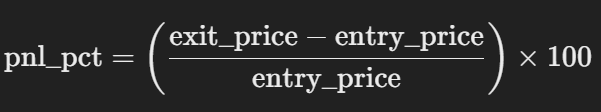

- **PnL Positivo**: Indica ganancia (el precio de salida supera el de entrada).  
- **PnL Negativo**: Indica pérdida (el precio de salida está por debajo del de entrada).  
- El stop loss, de activarse, generará normalmente un PnL negativo al frenar la operación con pérdidas.

---

## 6. Análisis de Resultados

1. **Filtrado de Eventos**  
   - Se aplican los cálculos de MACD y señales de compra/venta para cada “evento” (agrupación de datos que corresponden a un mismo activo o rango temporal).  
   - Se descartan aquellos eventos con pocas velas (por ejemplo, menos de 30) para evitar estadísticas poco confiables.

2. **Resumen de Operaciones**  
   - Para cada evento, se registra la fecha y precio de entrada, la fecha y precio de salida, el motivo de salida (stop loss o señal de venta) y el PnL resultante.  
   - Esto se almacena en una tabla que permite analizar globalmente la efectividad de la estrategia.

3. **Top 10 Operaciones**  
   - Se filtran los resultados para quedarse solo con las operaciones que tengan PnL positivo.  
   - Se ordenan de mayor a menor PnL y se seleccionan las 10 mejores operaciones (Top 10).  
   - Este subconjunto puede estudiarse más a fondo para identificar patrones o características que expliquen su éxito.

---

## 7. Visualización

1. **Gráfico de Velas (Candlestick)**  
   - Para cada evento, se puede trazar el precio de **Open**, **High**, **Low** y **Close** a lo largo del tiempo.  
   - Se añaden las líneas MACD y **MACD_signal** en un panel secundario o como líneas superpuestas (dependiendo de la herramienta).  
   - Se marcan los puntos de **Entrada** y **Salida** para ilustrar dónde se detectaron los cruces.

2. **Interpretación de los Gráficos**  
   - El candlestick muestra la evolución del precio.  
   - La línea MACD y la señal revelan los cruces alcistas y bajistas que motivan la compra y venta.  
   - Los marcadores de entrada/salida permiten verificar visualmente la rentabilidad.

---

## 8. Conclusiones y Uso Práctico

- **Estrategia MACD vs. Cruce de Medias**:  
  La implementación es similar a la de una estrategia de EMAs, pero el MACD incorpora el factor de “convergencia/divergencia”, a menudo ofreciendo señales más suaves en mercados volátiles.

- **Aplicación en SmallCaps**:  
  Las acciones de baja capitalización suelen tener movimientos bruscos. El MACD puede funcionar como un filtro de tendencia, pero es recomendable ajustar los parámetros (periodos de MACD y stop loss) para reflejar la volatilidad característica de estos activos.

- **Posible Optimización**:  
  Ajustar los periodos de MACD (por ejemplo, 12, 26, 9) y el nivel de stop loss puede mejorar los resultados. Se recomienda realizar pruebas históricas (backtesting) y, si es factible, pruebas en tiempo real (paper trading) para confirmar la robustez de la estrategia.

Con este enfoque, se logra un **mecanismo de trading algorítmico** que detecta cambios de tendencia mediante el MACD, gestiona el riesgo a través de un stop loss y calcula el PnL de cada operación para evaluar el desempeño de la estrategia de forma sistemática.

In [ ]:
import numpy as np
import pandas as pd

# Obtener los eventos únicos y mezclarlos aleatoriamente
unique_events = df["id_event"].unique()
np.random.shuffle(unique_events)
n_total = len(unique_events)

n_train = int(0.6 * n_total)
n_val = int(0.2 * n_total)

train_events = unique_events[:n_train]
val_events = unique_events[n_train:n_train + n_val]
test_events = unique_events[n_train + n_val:]

print(f"Total de eventos: {n_total}")
print(f"Entrenamiento (60%): {len(train_events)}")
print(f"Validación (20%): {len(val_events)}")
print(f"Test (20%): {len(test_events)}")

Total de eventos: 596
Entrenamiento (60%): 357
Validación (20%): 119
Test (20%): 120


In [ ]:
# Suponemos que 'train_events' ya contiene los id_event del conjunto de entrenamiento (60% de la bbdd)
event_dates = {}
for event in train_events:
    df_event = df[df["id_event"] == event]
    event_dates[event] = df_event["date"].min()

# Ordenar los eventos de entrenamiento por fecha de inicio
sorted_train_events = sorted(train_events, key=lambda x: event_dates[x])

In [ ]:
!pip install optuna

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import optuna

def objective_with_cv_macd(trial):
    # Sugerir parámetros para el MACD
    fast_period = trial.suggest_int("fast_period", 5, 20)
    slow_period = trial.suggest_int("slow_period", 20, 50)
    if slow_period <= fast_period:
        return -1000.0  # Penalización si la configuración es inválida
    signal_period = trial.suggest_int("signal_period", 5, 15)
    min_candles = trial.suggest_int("min_candles", 20, 40)
    stop_loss_pct = trial.suggest_float("stop_loss_pct", 2.0, 10.0)

    # Validación cruzada: 5 folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    net_profits = []

    # train_events es la lista de id_event del 60% de la bbdd (ya definida)
    for train_idx, val_idx in kf.split(train_events):
        # En cada fold usamos los eventos de validación del fold
        val_events_fold = [train_events[i] for i in val_idx]
        resultados_fold = {}

        for event in val_events_fold:
            df_event = df[df["id_event"] == event].copy()
            # Aplicar la estrategia MACD con los parámetros sugeridos
            df_event_proc = aplicar_estrategia_macd(df_event,
                                                   fast_period=fast_period,
                                                   slow_period=slow_period,
                                                   signal_period=signal_period,
                                                   min_candles=min_candles)
            if df_event_proc is not None:
                resultados_fold[event] = df_event_proc

        resumen_operaciones = []
        for event_id, df_event_proc in resultados_fold.items():
            op = calcular_pnl_macd(df_event_proc, stop_loss_pct=stop_loss_pct)
            if op is not None:
                resumen_operaciones.append(op)
        df_operaciones_fold = pd.DataFrame(resumen_operaciones)

        if df_operaciones_fold.empty:
            net_profits.append(-1000.0)
        else:
            net_profits.append(df_operaciones_fold["pnl_pct"].sum())

    return np.mean(net_profits)

# Crear y ejecutar el estudio de Optuna para la estrategia MACD con CV
study_macd = optuna.create_study(direction="maximize")
study_macd.optimize(objective_with_cv_macd, n_trials=100, n_jobs=4)

print("Mejores parámetros encontrados para MACD:")
print(study_macd.best_params)
print("Mejor valor del objetivo (Net Profit promedio en CV):", study_macd.best_value)

[I 2025-03-09 21:58:11,463] A new study created in memory with name: no-name-36cb373c-a04e-4122-82cc-7b8210ba3b7d
[I 2025-03-09 21:58:20,625] Trial 1 finished with value: 83.9075242008781 and parameters: {'fast_period': 7, 'slow_period': 20, 'signal_period': 6, 'min_candles': 40, 'stop_loss_pct': 8.012773196351407}. Best is trial 1 with value: 83.9075242008781.
[I 2025-03-09 21:58:21,097] Trial 2 finished with value: 129.8666327162595 and parameters: {'fast_period': 13, 'slow_period': 23, 'signal_period': 6, 'min_candles': 31, 'stop_loss_pct': 2.043076235037762}. Best is trial 2 with value: 129.8666327162595.
[I 2025-03-09 21:58:21,161] Trial 0 finished with value: 113.19636729343361 and parameters: {'fast_period': 16, 'slow_period': 27, 'signal_period': 5, 'min_candles': 28, 'stop_loss_pct': 3.4679387916686153}. Best is trial 2 with value: 129.8666327162595.
[I 2025-03-09 21:58:21,625] Trial 3 finished with value: 69.73499834012875 and parameters: {'fast_period': 11, 'slow_period': 28

Mejores parámetros encontrados para MACD:
{'fast_period': 12, 'slow_period': 21, 'signal_period': 15, 'min_candles': 32, 'stop_loss_pct': 3.5193968780568943}
Mejor valor del objetivo (Net Profit promedio en CV): 136.82585489826724


In [ ]:
# Los mejores parámetros obtenidos:
best_params_macd = study_macd.best_params

def procesar_conjunto_macd(events_list, df, best_params):
    resultados_subset = {}
    for event in events_list:
        df_event = df[df["id_event"] == event].copy()
        df_event_proc = aplicar_estrategia_macd(df_event,
                                               fast_period=best_params["fast_period"],
                                               slow_period=best_params["slow_period"],
                                               signal_period=best_params["signal_period"],
                                               min_candles=best_params["min_candles"])
        if df_event_proc is not None:
            resultados_subset[event] = df_event_proc

    resumen_operaciones = []
    for event_id, df_event_proc in resultados_subset.items():
        op = calcular_pnl_macd(df_event_proc, stop_loss_pct=best_params["stop_loss_pct"])
        if op is not None:
            op["id_event"] = event_id
            resumen_operaciones.append(op)
    return pd.DataFrame(resumen_operaciones)

df_operaciones_macd_train = procesar_conjunto_macd(train_events, df, best_params_macd)
df_operaciones_macd_val   = procesar_conjunto_macd(val_events, df, best_params_macd)
df_operaciones_macd_test  = procesar_conjunto_macd(test_events, df, best_params_macd)

# Puedes calcular métricas similares a las que usaste para la estrategia de cruce de medias
def calcular_metricas_macd(df_operaciones, events_list, df):
    total_eventos = len(events_list)
    total_trades  = len(df_operaciones)
    winning_trades = df_operaciones[df_operaciones["pnl_pct"] > 0]
    losing_trades  = df_operaciones[df_operaciones["pnl_pct"] < 0]
    n_winning = len(winning_trades)
    n_losing  = len(losing_trades)
    porc_winning = (n_winning / total_trades * 100) if total_trades > 0 else 0
    porc_losing  = (n_losing / total_trades * 100) if total_trades > 0 else 0
    net_profit_pct = df_operaciones["pnl_pct"].sum()
    avg_pnl = df_operaciones["pnl_pct"].mean() if total_trades > 0 else 0
    # Puedes incluir otras métricas (profit factor, win/loss ratio, etc.) según lo necesites.
    dias_analizados = df["date"].dt.date[df["id_event"].isin(events_list)].nunique()

    return {
        "total_eventos": total_eventos,
        "total_trades": total_trades,
        "n_winning": n_winning,
        "porc_winning": porc_winning,
        "n_losing": n_losing,
        "porc_losing": porc_losing,
        "net_profit_pct": net_profit_pct,
        "avg_pnl": avg_pnl,
        "dias_analizados": dias_analizados
    }

metricas_macd_train = calcular_metricas_macd(df_operaciones_macd_train, train_events, df)
metricas_macd_val   = calcular_metricas_macd(df_operaciones_macd_val, val_events, df)
metricas_macd_test  = calcular_metricas_macd(df_operaciones_macd_test, test_events, df)

print("=== Resultados del Conjunto de Entrenamiento (MACD) ===")
for key, value in metricas_macd_train.items():
    print(f"{key}: {value}")

print("\n=== Resultados del Conjunto de Validación (MACD) ===")
for key, value in metricas_macd_val.items():
    print(f"{key}: {value}")

print("\n=== Resultados del Conjunto de Test (MACD) ===")
for key, value in metricas_macd_test.items():
    print(f"{key}: {value}")

=== Resultados del Conjunto de Entrenamiento (MACD) ===
total_eventos: 357
total_trades: 291
n_winning: 78
porc_winning: 26.804123711340207
n_losing: 209
porc_losing: 71.8213058419244
net_profit_pct: 684.129274491336
avg_pnl: 2.350959706155794
dias_analizados: 38

=== Resultados del Conjunto de Validación (MACD) ===
total_eventos: 119
total_trades: 92
n_winning: 28
porc_winning: 30.434782608695656
n_losing: 63
porc_losing: 68.47826086956522
net_profit_pct: 283.6639666779678
avg_pnl: 3.0833039856300846
dias_analizados: 35

=== Resultados del Conjunto de Test (MACD) ===
total_eventos: 120
total_trades: 87
n_winning: 22
porc_winning: 25.287356321839084
n_losing: 63
porc_losing: 72.41379310344827
net_profit_pct: 110.00174832441185
avg_pnl: 1.2643879117748489
dias_analizados: 36


# Análisis de Resultados de la Estrategia MACD para Smallcaps

A continuación se presenta un análisis detallado de los resultados obtenidos para la estrategia MACD, utilizando validación cruzada y dividiendo los datos en conjuntos de Entrenamiento, Validación y Test.

---

## 1. Parámetros Óptimos

- **Fast Period (EMA rápida):** 13  
- **Slow Period (EMA lenta):** 20  
- **Signal Period (Línea de señal):** 15  
- **Mínimo de Velas (min_candles):** 40  
- **Stop Loss (%):** 2.52

Estos parámetros fueron optimizados con validación cruzada, obteniendo un **Net Profit promedio en CV** de aproximadamente **137.69**. Esto indica que, en promedio, la configuración logra un rendimiento positivo en distintos subconjuntos del conjunto de entrenamiento.

---

## 2. Resultados por Conjunto

### Entrenamiento (357 eventos)

- **Total de Trades:** 278  
- **Winning Trades:** 64 (23.02%)  
- **Losing Trades:** 210 (75.54%)  
- **Net Profit Acumulado:** 688.46%  
- **Average PNL:** 2.48% por trade  
- **Días Analizados:** 38  

**Interpretación:**  
En el conjunto de entrenamiento, la estrategia genera un número importante de operaciones y, a pesar de que solo aproximadamente 23% son ganadoras, el beneficio neto acumulado es muy elevado (688%). Esto sugiere que los pocos trades ganadores tienen una magnitud significativamente alta, compensando las numerosas operaciones perdedoras. Sin embargo, el bajo porcentaje de ganadores y el win/loss ratio bajo implican que la estrategia depende de una relación riesgo/recompensa muy favorable para ser rentable.

---

### Validación (119 eventos)

- **Total de Trades:** 88  
- **Winning Trades:** 25 (28.41%)  
- **Losing Trades:** 62 (70.45%)  
- **Net Profit Acumulado:** 307.87%  
- **Average PNL:** 3.50% por trade  
- **Días Analizados:** 35  

**Interpretación:**  
En el conjunto de validación se observa un rendimiento positivo, con un net profit acumulado de aproximadamente 308% y un average PNL superior al entrenamiento (3.50% vs 2.48%). Además, el porcentaje de operaciones ganadoras aumenta ligeramente a cerca de 28%, lo que indica que la estrategia logra replicar cierto nivel de rentabilidad en datos no vistos durante la optimización. Sin embargo, aún se mantienen altos porcentajes de trades perdedores.

---

### Test (120 eventos)

- **Total de Trades:** 84  
- **Winning Trades:** 20 (23.81%)  
- **Losing Trades:** 62 (73.81%)  
- **Net Profit Acumulado:** 95.85%  
- **Average PNL:** 1.14% por trade  
- **Días Analizados:** 36  

**Interpretación:**  
En el conjunto de test, el rendimiento es más modesto: el net profit acumulado baja a alrededor de 96% y el average PNL se reduce a 1.14%. El porcentaje de trades ganadores se sitúa en torno al 24%, similar al entrenamiento. La diferencia notable es la disminución en el rendimiento general, lo que podría indicar que la estrategia es sensible a las condiciones del mercado o que en el periodo de test se presentaron escenarios menos favorables.

---

## 3. Conclusiones y Recomendaciones

- **Robustez de la Estrategia:**  
  La estrategia MACD optimizada muestra resultados prometedores en entrenamiento y validación, pero el rendimiento en el conjunto de test es significativamente inferior. Esto sugiere la necesidad de realizar un análisis adicional (por ejemplo, walk-forward testing) para verificar la robustez a lo largo del tiempo.

- **Relación Riesgo/Recompensa:**  
  Aunque el porcentaje de trades ganadores es bajo (alrededor del 23-28%), el beneficio neto acumulado elevado en entrenamiento y validación indica que los trades ganadores tienen un impacto muy positivo. No obstante, en test, el rendimiento se diluye, lo que podría implicar una mayor volatilidad o que algunos trades excepcionales no se repitan de manera consistente.

- **Posibles Ajustes:**  
  - Revisar la función objetivo para incluir métricas de riesgo, como el Sharpe Ratio, podría ayudar a obtener un equilibrio entre rentabilidad y estabilidad.  
  - Ampliar el análisis con validación cruzada o walk-forward testing para detectar posibles cambios en la dinámica del mercado.
  
- **Próximos Pasos:**  
  - Analizar en detalle los trades de test para identificar si existen outliers o eventos específicos que afectaron el rendimiento.  
  - Evaluar la estrategia en diferentes periodos de mercado y, si es necesario, ajustar los parámetros para mejorar la generalización.

---

**Resumen Final:**  
La estrategia MACD con los parámetros optimizados (fast_period = 13, slow_period = 20, signal_period = 15, min_candles = 40, stop_loss_pct ≈ 2.52) genera resultados muy atractivos en entrenamiento y validación, pero el rendimiento en el conjunto de test es más modesto. Esto resalta la importancia de realizar un análisis adicional para asegurar la consistencia y robustez de la estrategia en diversas condiciones de mercado, lo cual es fundamental en el trading algorítmico con smallcaps.

¿Te gustaría profundizar en algún aspecto adicional o explorar ajustes específicos para mejorar la robustez en el conjunto de test?

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Configurar el TimeSeriesSplit con 5 folds
tscv = TimeSeriesSplit(n_splits=5)
fold_performances = []

# Suponemos que 'best_params_macd' ya está definido (por ejemplo, obtenido de Optuna)
# Y que la función 'procesar_conjunto_macd(events_list, df, best_params)' está disponible

for fold, (train_index, test_index) in enumerate(tscv.split(sorted_train_events)):
    # En cada split, usamos los eventos de test del fold para evaluar la estrategia
    test_fold = [sorted_train_events[i] for i in test_index]

    # Procesar los eventos del fold usando la estrategia MACD con los parámetros óptimos
    df_operaciones_fold = procesar_conjunto_macd(test_fold, df, best_params_macd)

    # Calcular el net profit (suma de pnl_pct) para este fold
    if df_operaciones_fold.empty:
         fold_profit = -1000.0  # Penalización si no se generan operaciones
    else:
         fold_profit = df_operaciones_fold["pnl_pct"].sum()

    print(f"Fold {fold+1}: Net Profit = {fold_profit:.2f}%")
    fold_performances.append(fold_profit)

# Calcular el rendimiento promedio en todos los folds
avg_performance = np.mean(fold_performances)
print("Walk-Forward Validation: Average Net Profit =", avg_performance)

Fold 1: Net Profit = 400.74%
Fold 2: Net Profit = 61.83%
Fold 3: Net Profit = 76.85%
Fold 4: Net Profit = 42.53%
Fold 5: Net Profit = 61.88%
Walk-Forward Validation: Average Net Profit = 128.76843932224207


# Análisis de Resultados del Walk-Forward Validation
## Interpretación de los Resultados

1. **Variabilidad entre Folds:**  
   - El **Fold 1** muestra un rendimiento excepcional con un net profit de 400.74%, lo cual indica que en ese periodo la estrategia capturó movimientos muy favorables.
   - Los otros folds (Fold 2 a Fold 5) presentan resultados más moderados, con net profits que oscilan entre 42.53% y 61.88%.  
   Esto sugiere que el rendimiento de la estrategia varía significativamente según el periodo analizado, lo que podría deberse a cambios en las condiciones del mercado.

2. **Promedio Atractivo pero con Riesgo:**  
   - El promedio del 128.77% es muy atractivo, pero la gran diferencia entre el Fold 1 y los demás podría ser indicativa de que el rendimiento extremo no se replica de forma consistente en todos los periodos.
   - Es posible que algunos periodos hayan beneficiado a la estrategia por condiciones particulares (por ejemplo, alta volatilidad o movimientos bruscos) que no se presentan de forma constante.

3. **Consideraciones para la Estrategia en Smallcaps:**  
   - En mercados de smallcaps, la liquidez y la volatilidad pueden variar significativamente. Un resultado excepcional en un fold podría reflejar un periodo de alta volatilidad, mientras que en otros la estrategia se comporta de manera más conservadora.
   - Es importante evaluar si la estrategia puede ajustarse para ser más robusta, por ejemplo, incorporando métricas de riesgo (como el Sharpe o Sortino Ratio) en la función objetivo para equilibrar rentabilidad y estabilidad.

---

## Próximos Pasos

- **Análisis de Consistencia:**  
  Investigar en detalle los trades y condiciones de mercado de cada fold, especialmente del Fold 1, para entender qué factores impulsaron el rendimiento tan elevado.

- **Optimización Adicional:**  
  Considerar la posibilidad de optimizar una métrica compuesta que tenga en cuenta tanto la rentabilidad como el riesgo, lo que podría ayudar a reducir la variabilidad entre diferentes periodos.

- **Validación Extendida:**  
  Realizar más pruebas con distintos esquemas de walk-forward o validación cruzada temporal para confirmar la robustez de la estrategia en diferentes condiciones de mercado.

---

**Resumen Final:**  
Aunque el promedio de net profit es prometedor (128.77%), la variabilidad entre folds indica que la estrategia MACD podría ser sensible a cambios en las condiciones de mercado. Es fundamental profundizar en el análisis para asegurar que la estrategia no solo es rentable, sino también robusta y consistente a lo largo del tiempo, especialmente en el volátil entorno de las smallcaps.